In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import pyfftw 

# 0. Notebook Goals/Aims

Goal of this notebook is to get used to working with [pyFFTW](https://pyfftw.readthedocs.io/en/latest/index.html) and building my intuition with how galaxies in postage stamps change when in Fourier Space.

This will be done by running [BTK](https://github.com/LSSTDESC/BlendingToolKit) isolated & blended galaxy images thru [pyFFTW](https://pyfftw.readthedocs.io/en/latest/index.html)'s FFT's to see how their properties change. 

# 1. Quick rundown of FT's/FFT's

The DFT is just a sum of many different dirac delta function added together to get the input signal/image. It is a transform from images into cycles/circles which is described by sines and cosines. See [this blog post](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/) for a good explanation.

## 1.1 DFT/IDFT

The **2D DFT** is defined as follows (i.e. going from spatial $\rightarrow$ frequency domain):

$$\mathbf{I}(u, v) = \frac{1}{N_{cols} \cdot N_{rows}} \sum_{x=0}^{N_{cols}-1}  \sum_{y=0}^{N_{rows}-1} I(x, y) \cdot exp \big[-i 2\pi \big(\frac{xu}{N_{cols}} + \frac{yv}{N_{rows}}\big) \big]$$

for **frequencies** $u = 0, 1, N_{cols} -1$ and $v = 0, 1,..., N_{rows}-1$. The image coordinates run from $0$ to $N_{cols}-1$ for $x$ and from $0$ to $N_{rows}-1$ for $y$. And note that:

$$exp(i\alpha) = e^{i\alpha} = cos\alpha + i \cdot sin\alpha$$

is the basis function.

---

The values $\mathbf{I}(u,v)$ of the Fourier transform of $I$, called *Fourier Coefficients*, are the weights in this sum with respect to the basis function $\exp(i\alpha)$. E.g. point noise or edges require sufficiently large coefficients for high frequency (i.e. short wavelength) components, to be properly represented in this weighted sum.

---

The **inverse 2D DFT** is (i.e. from frequency to spatial domain):

$$\mathbf{I}(x, y) = \sum_{x=0}^{N_{cols}-1}  \sum_{y=0}^{N_{rows}-1} I(u, v) \cdot exp \big[i 2\pi \big(\frac{xu}{N_{cols}} + \frac{yv}{N_{rows}}\big) \big]$$

Note that the powers of the root of unit are here reversed (minus sign replaced by plus sign) and that the DFT/IDFT can be written in many ways. The important thing is that the product of both scaling factors in the DFT and IDFT equals $1/N_{cols}\cdot N_{rows}$.

---

The FFT algorithm typically performs "in place": the original image is used for initializing the $N_{cols} \times N_{rows}$ matrix of the real part, and the matrix of the imaginary part is initialized by zero at all positions. Then the 2D FFT replaces all values in both matrices by 2D DFT results.

## 1.2 The Complex Plane

**Calculus of Complex Numbers:**

Let $z_1 = a_1 + i \cdot b_1$ and $z_2 = a_2 + i \cdot b_2$ be two complex numbers. The *real parts* $a_1$ and $a_2$, and *imaginary parts* $b_1$ and $b_2$. Properties of complex numbers are that:

- The sum of two complex numbers is a complex number and is invertible: $$z_1 + z_2 = (a_1 + a_2) + i \cdot (b_1 + b_2)$$

- The product of two complex numbers is a complex number and is invertible: $$z_1 \cdot z_2 (a_1a_2 - b_1b_2) + i \cdot (a_1b_2 + a_2b_1)$$

- The *norm* of a complex number $z = a + i\cdot b$ coincides with the $L_2$-length: $$|| z ||_{2} = \sqrt{a^2 + b^2}$$

- The *conjugate* $z^\star$ of a complex number is a complex number: $$ z^\star = a - i\cdot b$$

    - $(z^\star)^\star = z$
    - $(z_1 \cdot z_2)^\star = z_1^\star \cdot z_2^\star$

---
**Complex Numbers in Polar Coordinates:**

A complex number $z = a + ib$ can be written in the form $z = r \cdot e^{i\alpha}$, with $r = ||z||_{2}$ and $\alpha$ the complex argument of $z$ i.e. $b$ in the first equation. This maps complex numbers into polar coordinates $(r, \alpha)$.

A rotation of a vector $[c,d]^{T}$ (i.e. starting at the origin $[0,0]^{T}$ about an angle $\alpha$ is the vector $[a,b]^{T}$, with $$a + i\cdot b = e^{i\alpha} \cdot (c + i\cdot d)$$

---

**Roots of Unity:**

The complex number $$W_M = \text{exp}[i2\pi/M]$$ defines the Mth *root of unity*; we have $W_M^M = W_M^{2M} = W^{3M}_{M} = ... = 1$. Assume that M is a multiple of 4.

The figure below hows all of the powers of the 24th root of unity, i.e. $W_{24} = e^{i2\pi/24}$
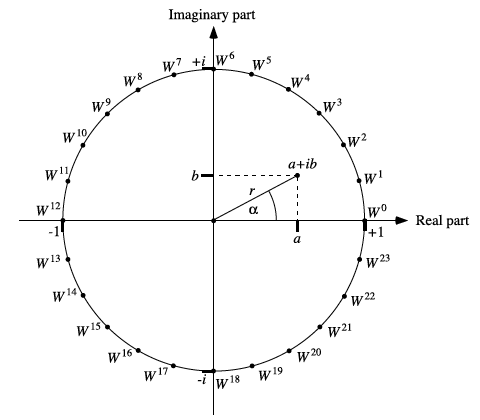


## 1.3 Image Data in the Frequency Domain

The values for low frequencies $u$ or $v$ (i.e. close to $0$) represent long wavelengths of sine or cosine components; values for large frequencies $u$ or $v$ (i.e. away from zero) represent short wavlengths.

---
**Interpretation of Matrix I:**

- Low frequencies represent long wavelength and thus homogeneous additive contributions to the input image $I$.

- High frequencies represent short wavelengths (and thus local discontinuities in $I$, such as edges or intensity outliers $\leftarrow$ like galaxies?).

- Directional patterns in $I$, for example lines into direction $\beta$ or $\beta + \pi$, create value distributions in $\mathbf{I}$ in the orthogonal direction (i.e., in direction $\beta + \pi/2$).

---
**Three properties of the DFT:**

Consider the 2D FT of an image $I$. It consists of two $N_{cols} \times N_{rows}$ arrays representing the real (i.e. the $a$s) and the imaginary part (i.e. the $b$s) of the obtained complex numbers $a + i \cdot b$. Thus, the $N_{cols} \times N_{rows}$ real data of the input image $I$ are now "doubled". But there are 3 important properties of the DFT:

1. **Symmetry Property:** $$\mathbf{I}(N_{cols} - u, N_{rows} - v) = \mathbf{I}(-u, -v) = \mathbf{I}(u, v)^\star$$
    Thus, actually half of the data in both arrays of $\mathbf{I}$ can be directly obtained from the other half.

2. **DC Component/Mean of I:** $$\mathbf{I}(0,0) = \frac{1}{N_{cols}\cdot N_{rows}} \sum_{x=0}^{N_{cols}-1} \sum_{y=0}^{N_{rows}-1} I(x, y)$$
    Because $I$ has only real values, it follows that the imaginary part of $\mathbf{I}(0,0)$ is always equal to zero and thus is known as the DC component of I. For any other frequency $(u,v_ \neq (0,0)$, $\mathbf{I}(u,v)$ is called the AC component of I.
    
3. **Parseval's Theorem:** Which states that the integral of the square of a function is equal to the integral of the square of its transform: $$\frac{1}{|\Omega|} \sum_{\Omega} |I(x,y)|^{2} = \sum_{\Omega} |\mathbf{I}(u,v)|^{2}$$
 
---
**Spectrum and Phase:**

The $L_2$-norm, *magnitude*, or *amplitude* $||z||_2 = r = \sqrt{a^2 + b^2}$, and the complex argument or *phase* $\alpha = \text{atan}2(b,a)$ define the complex numbers $z = a + i \cdot b$ in polar coordinates $(r, \alpha)$.

- The norm ($||z||_2 = r = \sqrt{a^2 + b^2}$) provides a convenient way of representing the complex-valued matrix $\mathbf{I}$ in the form of the **spectrum** $||\mathbf{I}||$. 

    - When visualizing the spectrum $||\mathbf{I}||$ in the form of a grey-level image, it would just be black with a bright dot at the origin (representing the mean). This is because all values in $||\mathbf{I}||$ are rather small.
        
        - For better visibility we usually log $||\mathbf{I}||$ so we get $\text{log}_{10}(1 + ||\mathbf{I}(u,v)||_2 $

- Here's an example of centered and log-transformed spectra. Remember that directional patterns in $I$ create value distributions in. $\mathbf{I}$ in the orthoganl direction.

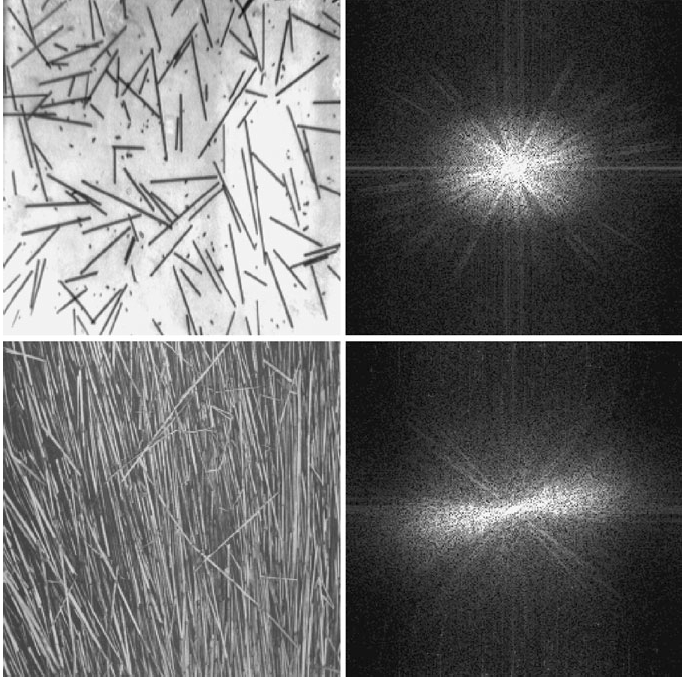

- Another examples with rotations of main directions being illustrated 

![Screen%20Shot%202022-09-06%20at%201.44.28%20PM.png](attachment:Screen%20Shot%202022-09-06%20at%201.44.28%20PM.png)

- Another example, where in the upper right example the additive behavior is illustrated
![Screen%20Shot%202022-09-06%20at%201.46.01%20PM.png](attachment:Screen%20Shot%202022-09-06%20at%201.46.01%20PM.png)

---
**Fourier Pairs:**

An input image and its FT define a *Fourier Pair*. Some properties of the FT are:


- $$I(x,y) \leftarrow \rightarrow \mathbf{I}(u,v)$$

- The FT of a convolution of $I$ with a filter kernel G (e.g. a PSF) equals a point-by-point product of values in the FTs of $I$ and G: $$ I * G(x,y) I(x,y) \leftarrow \rightarrow \mathbf{I} \circ \mathbf{G}(u,v)$$

- The FT can be centered if the input image is multiplied by a chessboard pattern of +1 and -1: $$I(x,y) \cdot (-1)^{x+y} \leftarrow \rightarrow \mathbf{I} \big(u + \frac{N_{cols}}{2}, v + \frac{N_{rows}}{2} \big)$$

- The FT is a linear transofrmation: $$a \cdot I(x,y) + b \cdot J(x,y) \leftarrow \rightarrow a \cdot \mathbf{I}(u,v) + b \cdot \mathbf{J}(u,v)$$

# 2. Create some images.

We create the images by doing everything up to the first blue box titled **"DrawBlendsGenerator"** in the figure below:

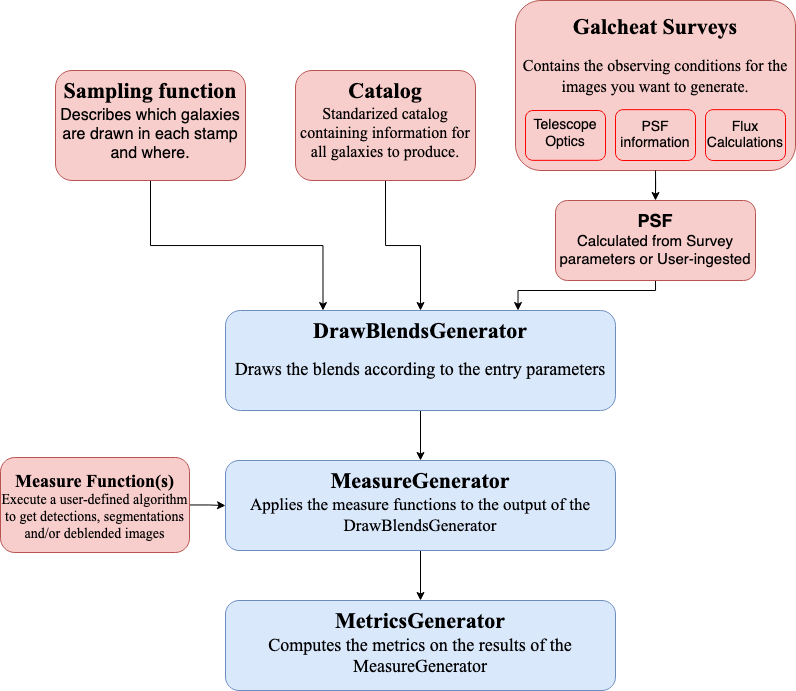

In [13]:
def BTK_blend_generator(catalog_name=None,
                        stamp_size=24.0,
                        max_number=2,
                        max_shift=0.0,
                        batch_size=10,
                        sampling_func=None,
                        survey="LSST",
                        add_noise="all"):
    
    """
    Helper function that puts the necessary pieces together to create
    a 'DrawBlendsGenerator' as shown in the diagram above. The "necessary
    pieces" are all the red boxes that flow into the first blue box.
    
    Args:
    -----
        catalog_name: str
            Path to the data file that you want to use to create the blends.
            Defaults to the OneDegSq.fits file.
        stamp_size: float
            Size of the stamp to be created, in arcseconds.
            Defaults to 24.0 arcseconds.
        max_number: int
            How many galaxies in the blend.
            Defaults to 2.
        max_shift: float
            Max shift of the galaxies from center, in arcseconds.
            Defaults to 0.0
        batch_size: int
            Number of samples you want to create from function call.
            Defaults to 10.
        sampling_func: btk.sampling_functions object
            Sampling function thatis used to produce blend tables.
            Defaults to btk.sampling_function.DefaultSampling()
        survey: str
            Name of the survey that you want to use. Returns specified
            surveys from galcheat extended to contain PSF information.
            Defaults to LSST.
        add_noise: str
            Add Poisson noise to the simulated survey image if requested.
            Defaults to "all".
        
    Returns:
    --------
        blend_images: np.ndarray
            Array containing the blended galaxy stamps.
            Array has shape: (N_samples, N_channels, H, W)
        isolated_images: np.ndarray
            Array containing the noise free individual galaxies
            that make up the blend image.
            Array has shape: (N_samples, max_number, N_channels, H, W)
    """
    
    
    # Catalog:
    #---------#
    if catalog_name == None:
        catalog_name = "/Users/matt/Desktop/UCI_Research/LSST/btk_blending/DS_creation/Data/OneDegSq.fits"
        catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
    else:
        catalog_name = str(catalog_name)
        catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

    # Setting parameter values:
    #-------------------#
    stamp_size = stamp_size # Size of the stamp, in arcseconds
    max_number = max_number # Max number of galaxies in a blend
    max_shift = max_shift # Max shift of the galaxies from center, in arcseconds

    # Sampling Function:
    #-------------------#
    if sampling_function == None:
        sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number,
                                                              stamp_size=stamp_size,
                                                              maxshift=max_shift)
    else:
        sampling_function = sampling_function

    # Survey
    #-------#
    LSST = btk.survey.get_surveys(str(survey))

    # Draw Blends:
    #-------------#
    draw_generator = btk.draw_blends.CatsimGenerator(
        catalog=catalog,
        sampling_function=sampling_function,
        surveys=LSST,
        batch_size=batch_size,
        stamp_size=stamp_size,
        cpus=1,
        add_noise=str(add_noise), 
        seed=1)

    # Sample the blends from the blends generator:
    #----------------------------------------------#
    batch = next(draw_generator)
    blend_images = batch['blend_images']
    blend_list = batch['blend_list']
    isolated_images = batch['isolated_images']
    
    return blend_images, isolated_images

In [8]:
# Catalog:
#---------#
catalog_name = "/Users/matt/Desktop/UCI_Research/LSST/btk_blending/DS_creation/Data/OneDegSq.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

# Setting parameter values:
#-------------------#
stamp_size = 24.0 # Size of the stamp, in arcseconds
max_number = 3 # Max number of galaxies in a blend
max_shift = 0.0 # Max shift of the galaxies from center, in arcseconds

# Sampling Function:
#-------------------#
sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number,
                                                          stamp_size=stamp_size,
                                                          maxshift=max_shift)

# Survey
#-------#
LSST = btk.survey.get_surveys("LSST")

# Draw Blends:
#-------------#
draw_generator = btk.draw_blends.CatsimGenerator(
    catalog=catalog,
    sampling_function=sampling_function,
    surveys=LSST,
    batch_size=10,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all", 
    seed=1)

# Sample the blends from the blends generator:
#----------------------------------------------#
batch = next(draw_generator)
blend_images = batch['blend_images']
blend_list = batch['blend_list']
isolated_images = batch['isolated_images']

# Set plotting params:
#---------------------#
indx = 0    # Sample number
cindx = 2   # Channel index (band number has 6 filters for LSST)
oindx = 0   # Object index (for the isolated images)

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
def iso_blended_plot(blend_images, isolated_images, indx, limits=(30,90)):
    """
    Function to plot the blended image and its constituent isolated
    galaxies in 3 LSST bands (gri) and a sum of all 6 bands.
    
    Args:
    -----
        blend_images: np.array
            The actual blended image with all the noise, as seen from the telescope.
        isolated_images: np.array
            The individual images that make-up the blend_images. These are noise free.
        indx: int
            The index of the sample to plot.
        limits: 
            
    Returns:
    --------
        matplotlib.imshow plot of the blended scene and its isolated galaxies
        in the 3 LSST filters (gri) and a sum of all the 6 bands.
    """
    # Number of galaxies in blend
    num_of_obj = isolated_images.shape[1] 
    
    # Creating the 3 band blend img & the 6-band summed blend img
    avg_blend_img = np.sum(blend_images[indx, :, :, :], axis=0)
    blend_3band = btk.plot_utils.get_rgb_image(blend_images[indx])
    
   
    fig, axes = plt.subplots(2, num_of_obj+1, figsize=(30,26))
    for i in range(num_of_obj+1):
        # First row of images will be the blended image in gri bands
        # and the sum over all bands
        axes[0,0].imshow(blend_3band)
        axes[0,0].set_xlim(limits)
        axes[0,0].set_ylim(limits)
        axes[0,0].axis('off')
        axes[0,0].set_title('Blend: gri bands', fontsize=30)
        axes[1,0].imshow(avg_blend_img)
        axes[1,0].set_xlim(limits)
        axes[1,0].set_ylim(limits)
        axes[1,0].axis('off')
        axes[1,0].set_title('Blend: Sum over bands', fontsize=30)

        # Create as many gri/sum over all band images for the
        # individual galaxies that make up the blended image.
        axes[0,i].imshow(btk.plot_utils.get_rgb_image(isolated_images[indx][i-1]))
        axes[0,i].set_xlim(limits) # set_xlim flips the axeses
        axes[0,i].set_ylim(limits)
        axes[0,i].axis('off')
        axes[0,i].set_title(f'Iso {i}: gri bands', fontsize=30)
        axes[1,i].imshow(np.sum(isolated_images[indx][i-1][:, :, :], axis=0))
        axes[1,i].set_xlim(limits)
        axes[1,i].set_ylim(limits)
        axes[1,i].axis('off')
        axes[1,i].set_title(f'Iso {i}: Sum over bands', fontsize=30)
        
    plt.tight_layout()
    plt.show()

In [4]:
isolated_images.shape

(10, 3, 6, 120, 120)

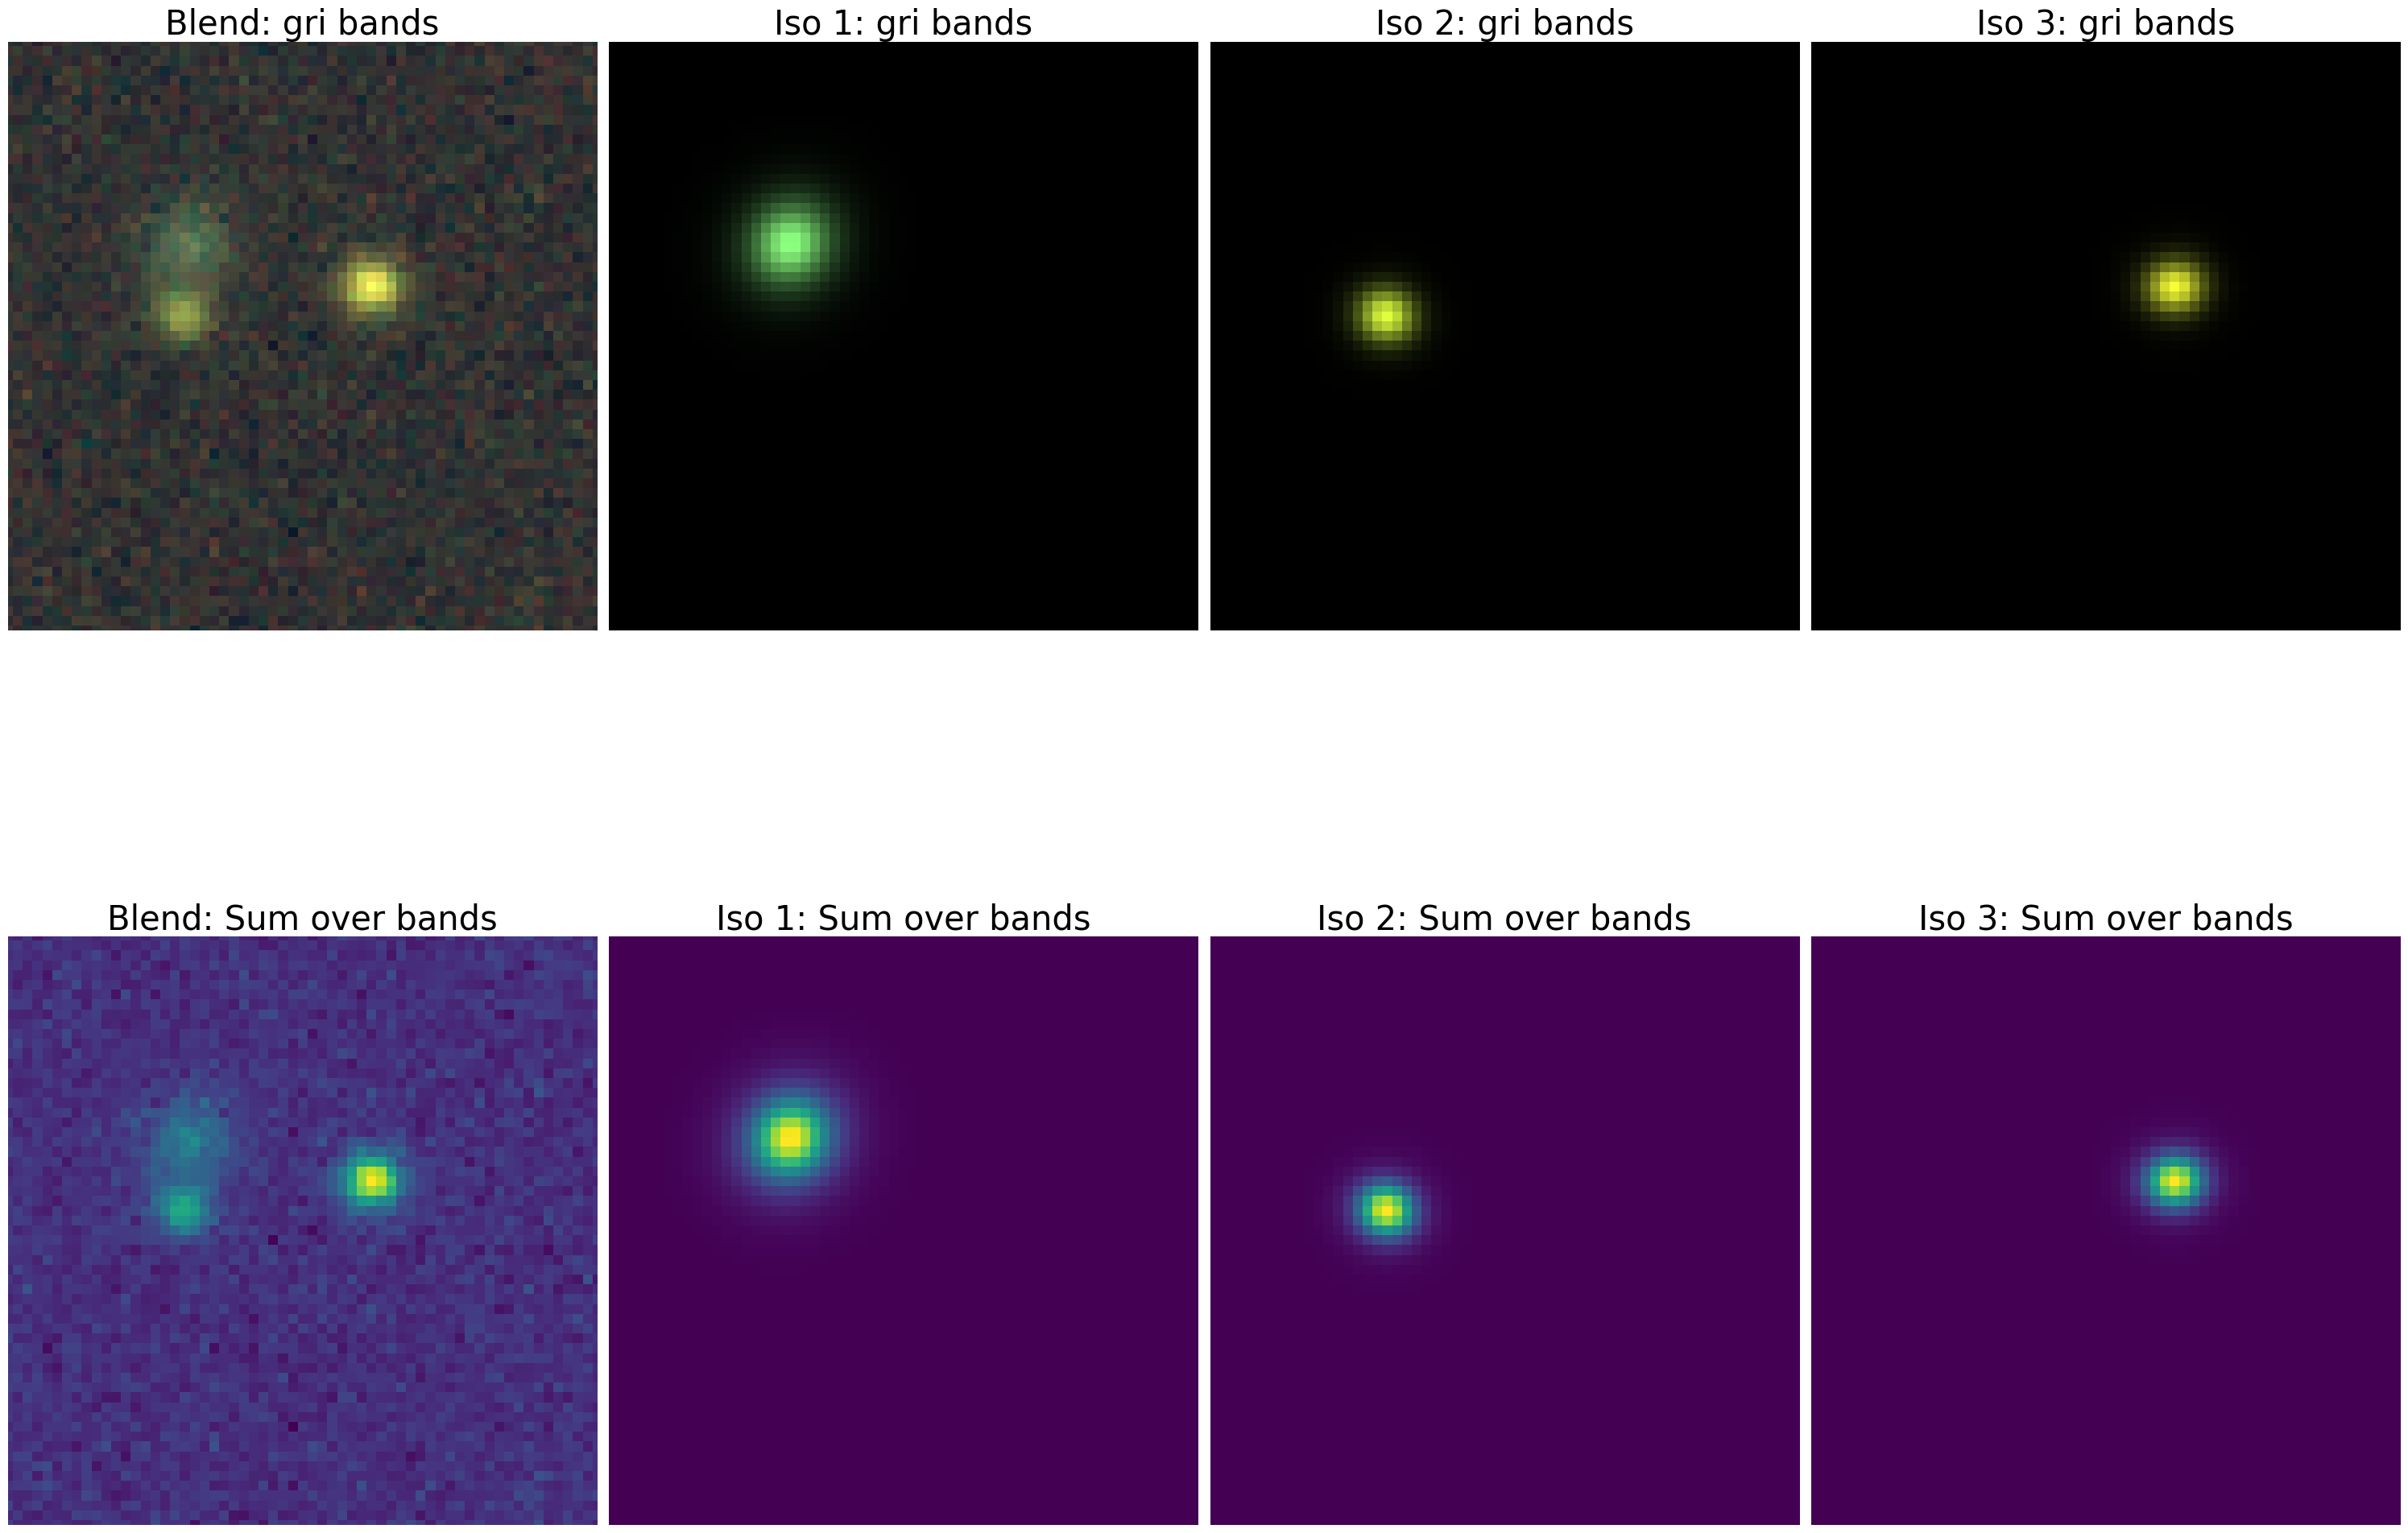

In [5]:
iso_blended_plot(blend_images=blend_images,
                 isolated_images=isolated_images,
                 indx=indx,
                 limits=(30,90))

`pyfftw.empty_aligned()` is a helper function that works like `numpy.empty()` but returns the array aligned to a particular number of bytes in memory. If the alignment is not specified then the library inspects the CPU for an appropriate alignment value. Having byte aligned arrays allows FFTW to performed vector operations, potentially speeding up the FFT.

In [6]:
isolated_images.shape

(10, 3, 6, 120, 120)

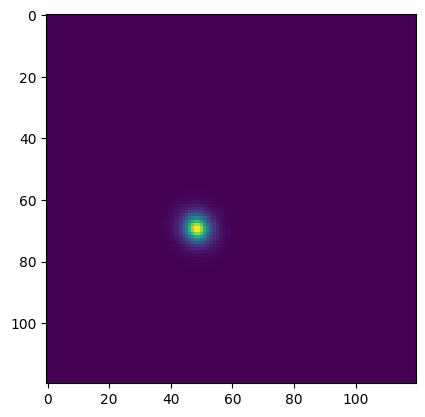

In [7]:
batch_i=0
gal_i=0
filter_i=5

plt.imshow(isolated_images[batch_i, gal_i,filter_i])

In [8]:
def calc_fft_spec(img, batch_i=0, gal_i=0, filter_i=0):
    """
    Function to calculate the 2D DFT spectrum for use
    in visualization purposes.
    
    Args:
    -----
        img: np.ndarray
            Either a blended galaxy image or an image of the
            individual galaxies that make up the blended image.
        batch_i: int
            The batch index. The index of the sample you want to
            visualize from the BTK created blended batch. 
            Defaults to the first sample in the batch.
        gal_i: int
            Galaxy index. If there are more than one galaxys in a blend
            this arg allows user specification for which galaxy 2D DFT
            spectrum to plot.
            Defaults to the first galaxy in the blend.
            NOTE: Only needed when calculating DFT for the isolated 
                  galaxies.
        filter_i: int
            Filter index. Which of the 6 LSST filters do you want to
            select for FT spectrum visualization.
            Defaults to 0.
    
    Returns:
    --------
        fft_spec: np.ndarray
            Returns the 2D DFT spectrum of the inputted galaxy image.
            Array will have shape: (H, W)
    """
    
    # i.e. if the image is an isolated galaxy image
    if img.ndim == 5:
        input_gal = img[batch_i,gal_i, filter_i]
        H, W = input_gal.shape

        # Create and fill np.float64 array 'img'
        # NOTE: Make the dtype not hard-coded
        img = pyfftw.empty_aligned((H, W), dtype=np.float64) 
        img[:, :] = input_gal
        # 2D DFT of the image
        fft_obj = pyfftw.interfaces.numpy_fft.fft2(img)
        # Take the absolute value of the image ie. get the magnitude of the image
        fft_spectrum = np.abs(fft_obj)
        # Log it for viewing purposes
        fft_spec = np.log(1 + fft_spectrum)
        # Shift the FT so that the DC component is in the center
        fft_spec = pyfftw.interfaces.numpy_fft.fftshift(fft_spec)
        
        return input_gal, fft_spec
        
    # i.e. if the image is a blended image
    else:
        input_blend = img[batch_i, filter_i]
        H, W = input_blend.shape

        # Create and fill np.float64 array 'img'
        # Make the dtype not hard-coded
        img = pyfftw.empty_aligned((H, W), dtype=np.float64) 
        img[:, :] = input_blend
        # 2D DFT of the image
        fft_obj = pyfftw.interfaces.numpy_fft.fft2(img)
        # Take the absolute value of the image ie. get the magnitude of the image
        fft_spectrum = np.abs(fft_obj)
        # Log it for viewing purposes
        fft_spec = np.log(1 + fft_spectrum)
        # Shift the FT so that the DC component is in the center
        fft_spec = pyfftw.interfaces.numpy_fft.fftshift(fft_spec)
    
        return input_blend, fft_spec

def plot_iso_fft(iso_img, batch_i=0, gal_i=0, filter_i=0):
    """
    Function that plots the 2D DFT spectrum
    of isolated galaxy images.
    
    Note: Uses the pyFFTW numpy interface.
    
    Args:
    -----
        img: np.ndarray
            The individual images that make-up the blend_images.
            Array has shape of:
                shape = (N_samples, N_gals in blend, N_channels, H, W)
            These are noise free.
        batch_i: int
            The batch index. The index of the sample you want to
            visualize from the BTK created blended batch. 
            Defaults to the first sample in the batch.
        gal_i: int
            Galaxy index. If there are more than one galaxys in a blend
            this arg allows user specification for which galaxy 2D DFT
            spectrum to plot.
            Defaults to the first galaxy in the blend.
        filter_i: int
            Filter index. Which of the 6 LSST filters do you want to
            select for FT spectrum visualization.
            Defaults to 0.
            
    Returns:
    --------
        matplotlib.imshow plot of the FT spectrum of the inputted galaxy.
    """
       
    input_gal, iso_spectrum = calc_fft_spec(img=iso_img,
                                            batch_i=batch_i,
                                            gal_i=gal_i,
                                            filter_i=filter_i)
    
    fig, axes = plt.subplots(1, 2, figsize=(30,26))
    axes[0].imshow(input_gal)
    axes[0].axis('off')
    axes[0].set_title('Input Image: Isolated', fontsize=40)
    axes[1].imshow(iso_spectrum)
    axes[1].axis('off')
    axes[1].set_title('Iso FT', fontsize=40)
    
    plt.tight_layout()
    plt.show()    
    
    
def plot_blended_fft(blend_img, batch_i=0,filter_i=0):
    """
    Function that plots the 2D DFT spectrum
    of the blended galaxy image.
    
    Note: Uses the pyFFTW numpy interface.
    
    Args:
    -----
        gal: np.ndarray
            Array of unique stamps of blended images.
            Array has shape of:
                shape = (N_samples, N_channels, H, W)
            These can be toggled to be noise free.
        batch_i: int
            The batch index. The index of the sample you want to
            visualize from the BTK created blended batch. 
            Defaults to the first sample in the batch.
        filter_i: int
            Filter index. Which of the 6 LSST filters do you want to
            select for FT spectrum visualization.
            Defaults to 0.
            
    Returns:
    --------
        matplotlib.imshow plot of the FT spectrum of the inputted 
        blended image.
    """
    input_blend, blend_spectrum = calc_fft_spec(img=blend_img,
                                                batch_i=batch_i,
                                                filter_i=filter_i)
        
    fig, axes = plt.subplots(1, 2, figsize=(30,26))
    axes[0].imshow(input_blend)
    axes[0].axis('off')
    axes[0].set_title('Input Image: Blend', fontsize=40)
    axes[1].imshow(blend_spectrum)
    axes[1].axis('off')
    axes[1].set_title('Blend FT', fontsize=40)
    
    plt.tight_layout()
    plt.show()
    
    
def plot_fft(blend_img, isolated_img, batch_i=0, filter_i=0, gal_i=0):
    """
    Function that plots the blended and isolated galaxy images
    and their respective 2D DFT spectrums.
    
   
    Args:
    -----
        blend_imgs: np.ndarray
            Array of various blended galaxy stamps.
            Array has shape of:
                shape = (N_samples, N_channels, H, W)
            These can be toggled to be noise free.
        isolated_imgs: np.ndarray
            The individual images that make-up the blend_imgs.
            Array has shape of:
                shape = (N_samples, N_gals in blend, N_channels, H, W)
            These are noise free.
        batch_i: int
            The batch index. The index of the sample you want to
            visualize from the BTK created blended batch. 
            Defaults to the first sample in the batch.
        gal_i: int
            Galaxy index. If there are more than one galaxys in a blend
            this arg allows user specification for which galaxy 2D DFT
            spectrum to plot.
            Defaults to the first galaxy in the blend.
        filter_i: int
            Filter index. Which of the 6 LSST filters do you want to
            select for FT spectrum visualization.
            Defaults to 0.
            
    Returns:
    --------
        matplotlib.imshow plot of the inputted galaxy blend and constituent
        isolated noise-free galaxies, as well as, the respective 2D DFT 
        spectrums of the blended and isolated galaxy scenes.
    """
    
    plot_blended_fft(blend_img=blend_img,
                      batch_i=batch_i,
                      filter_i=filter_i)
    
    plot_iso_fft(iso_img=isolated_img,
                 batch_i=batch_i,
                 gal_i=gal_i,
                 filter_i=filter_i)

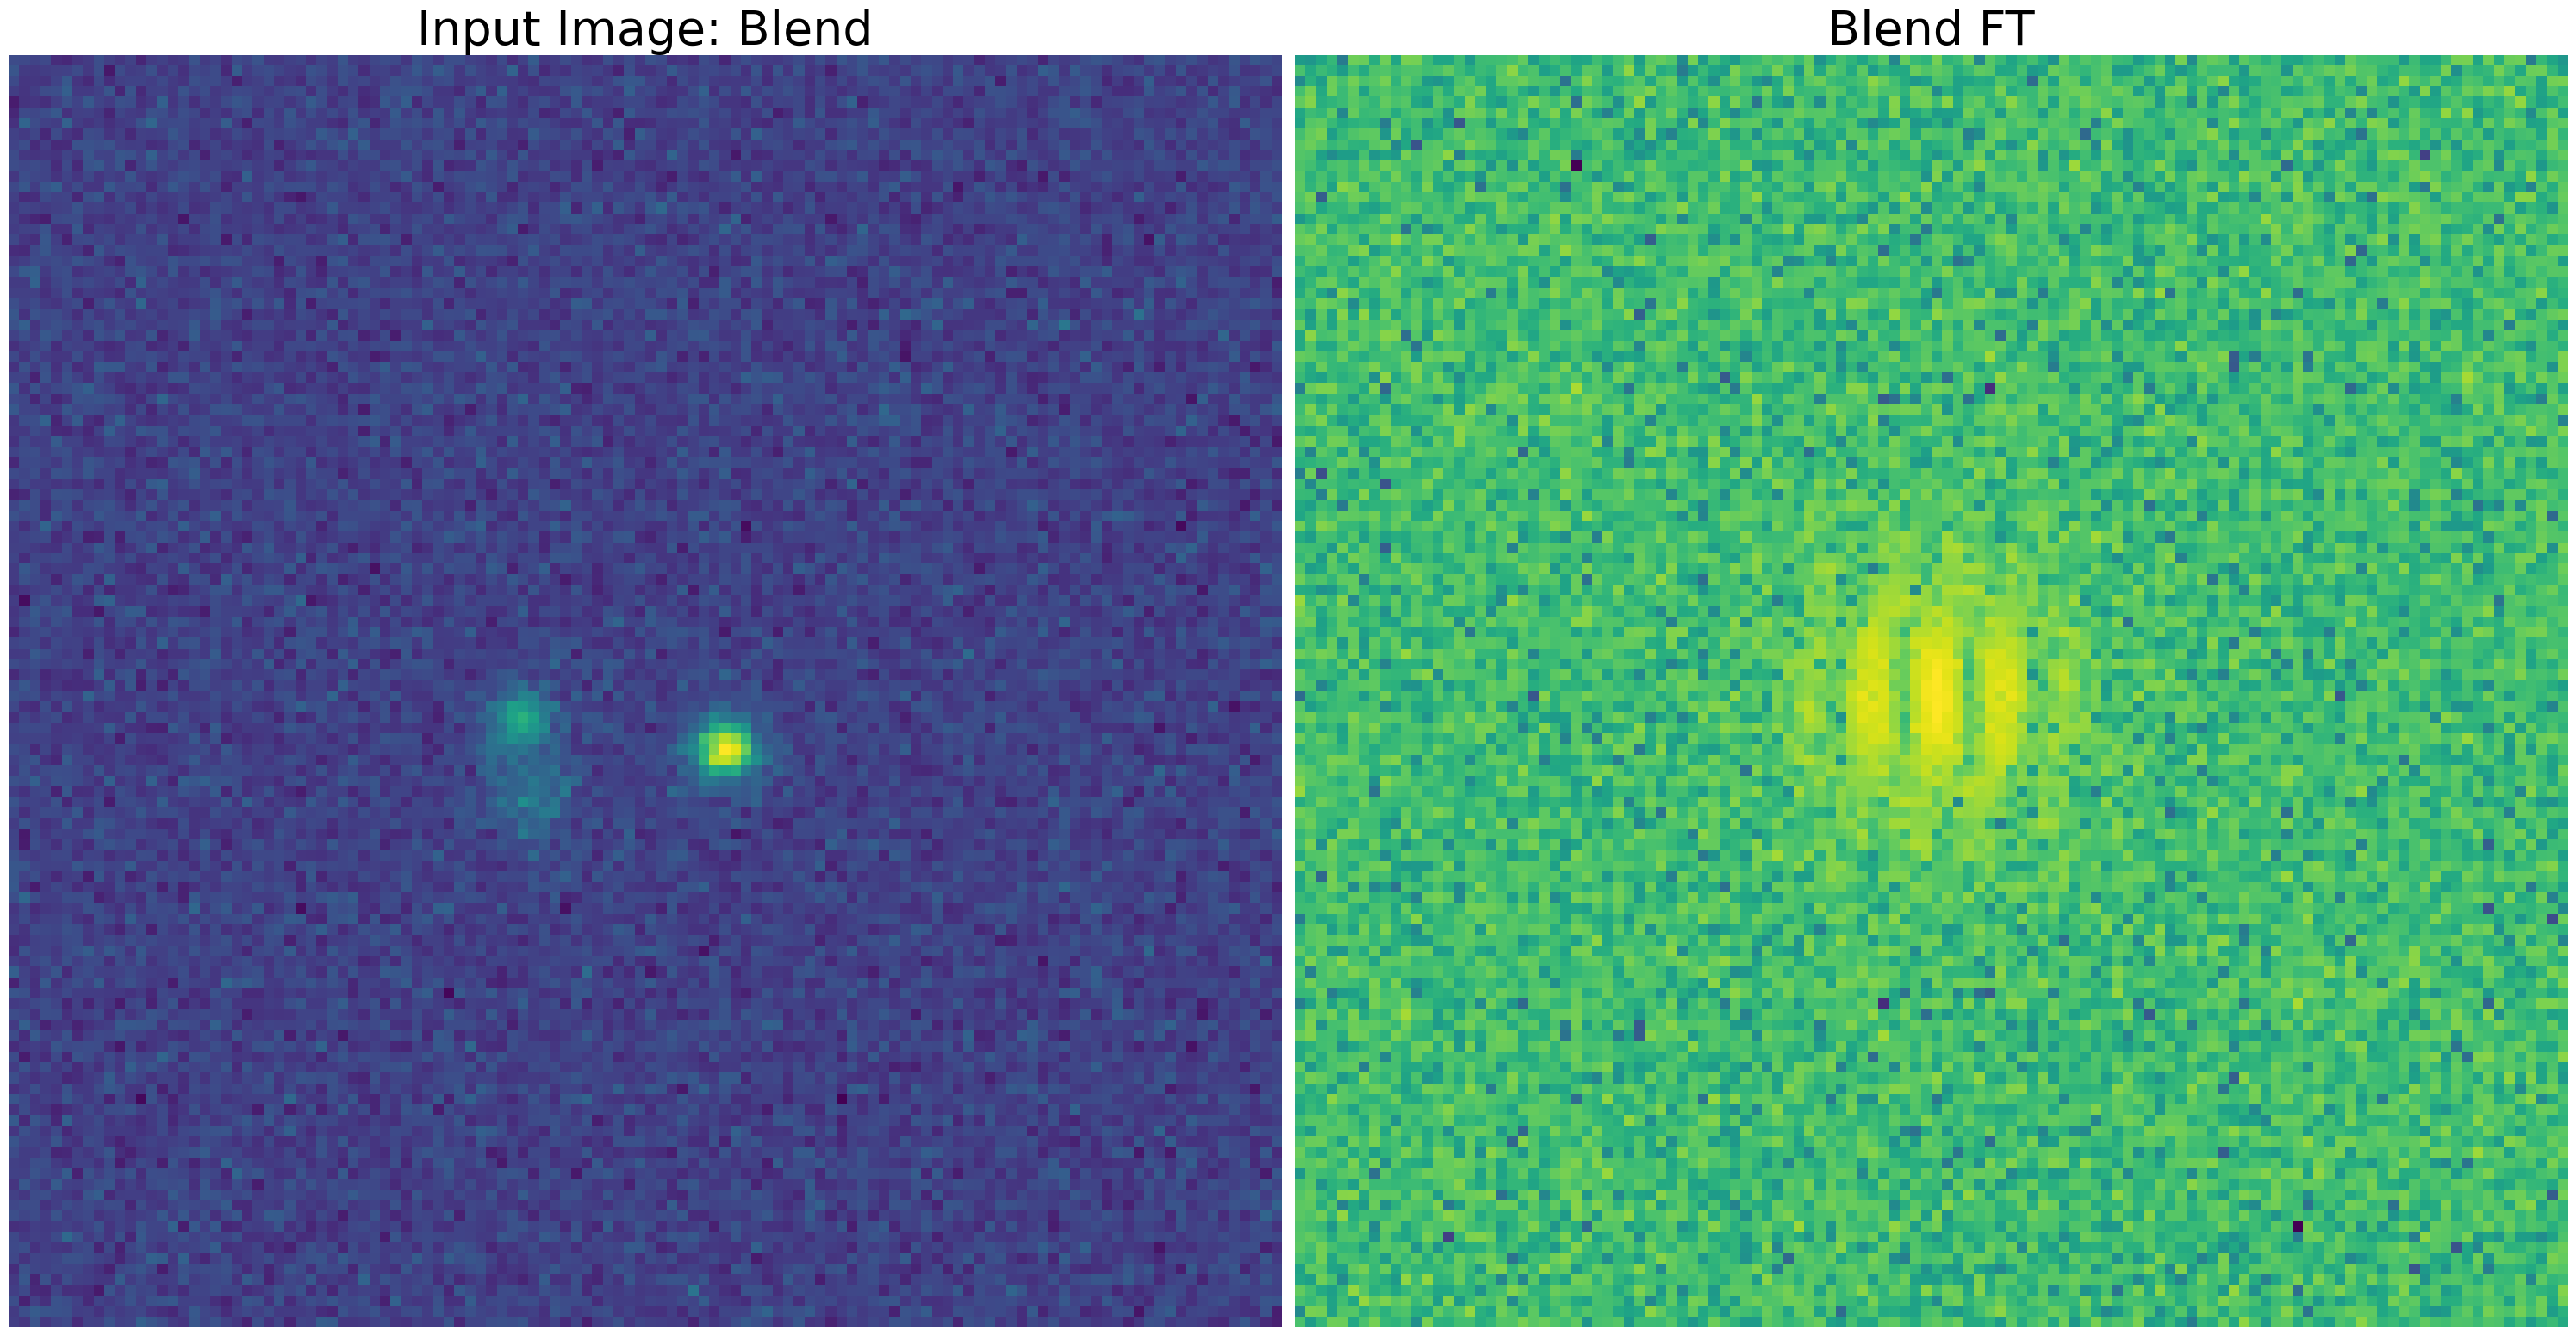

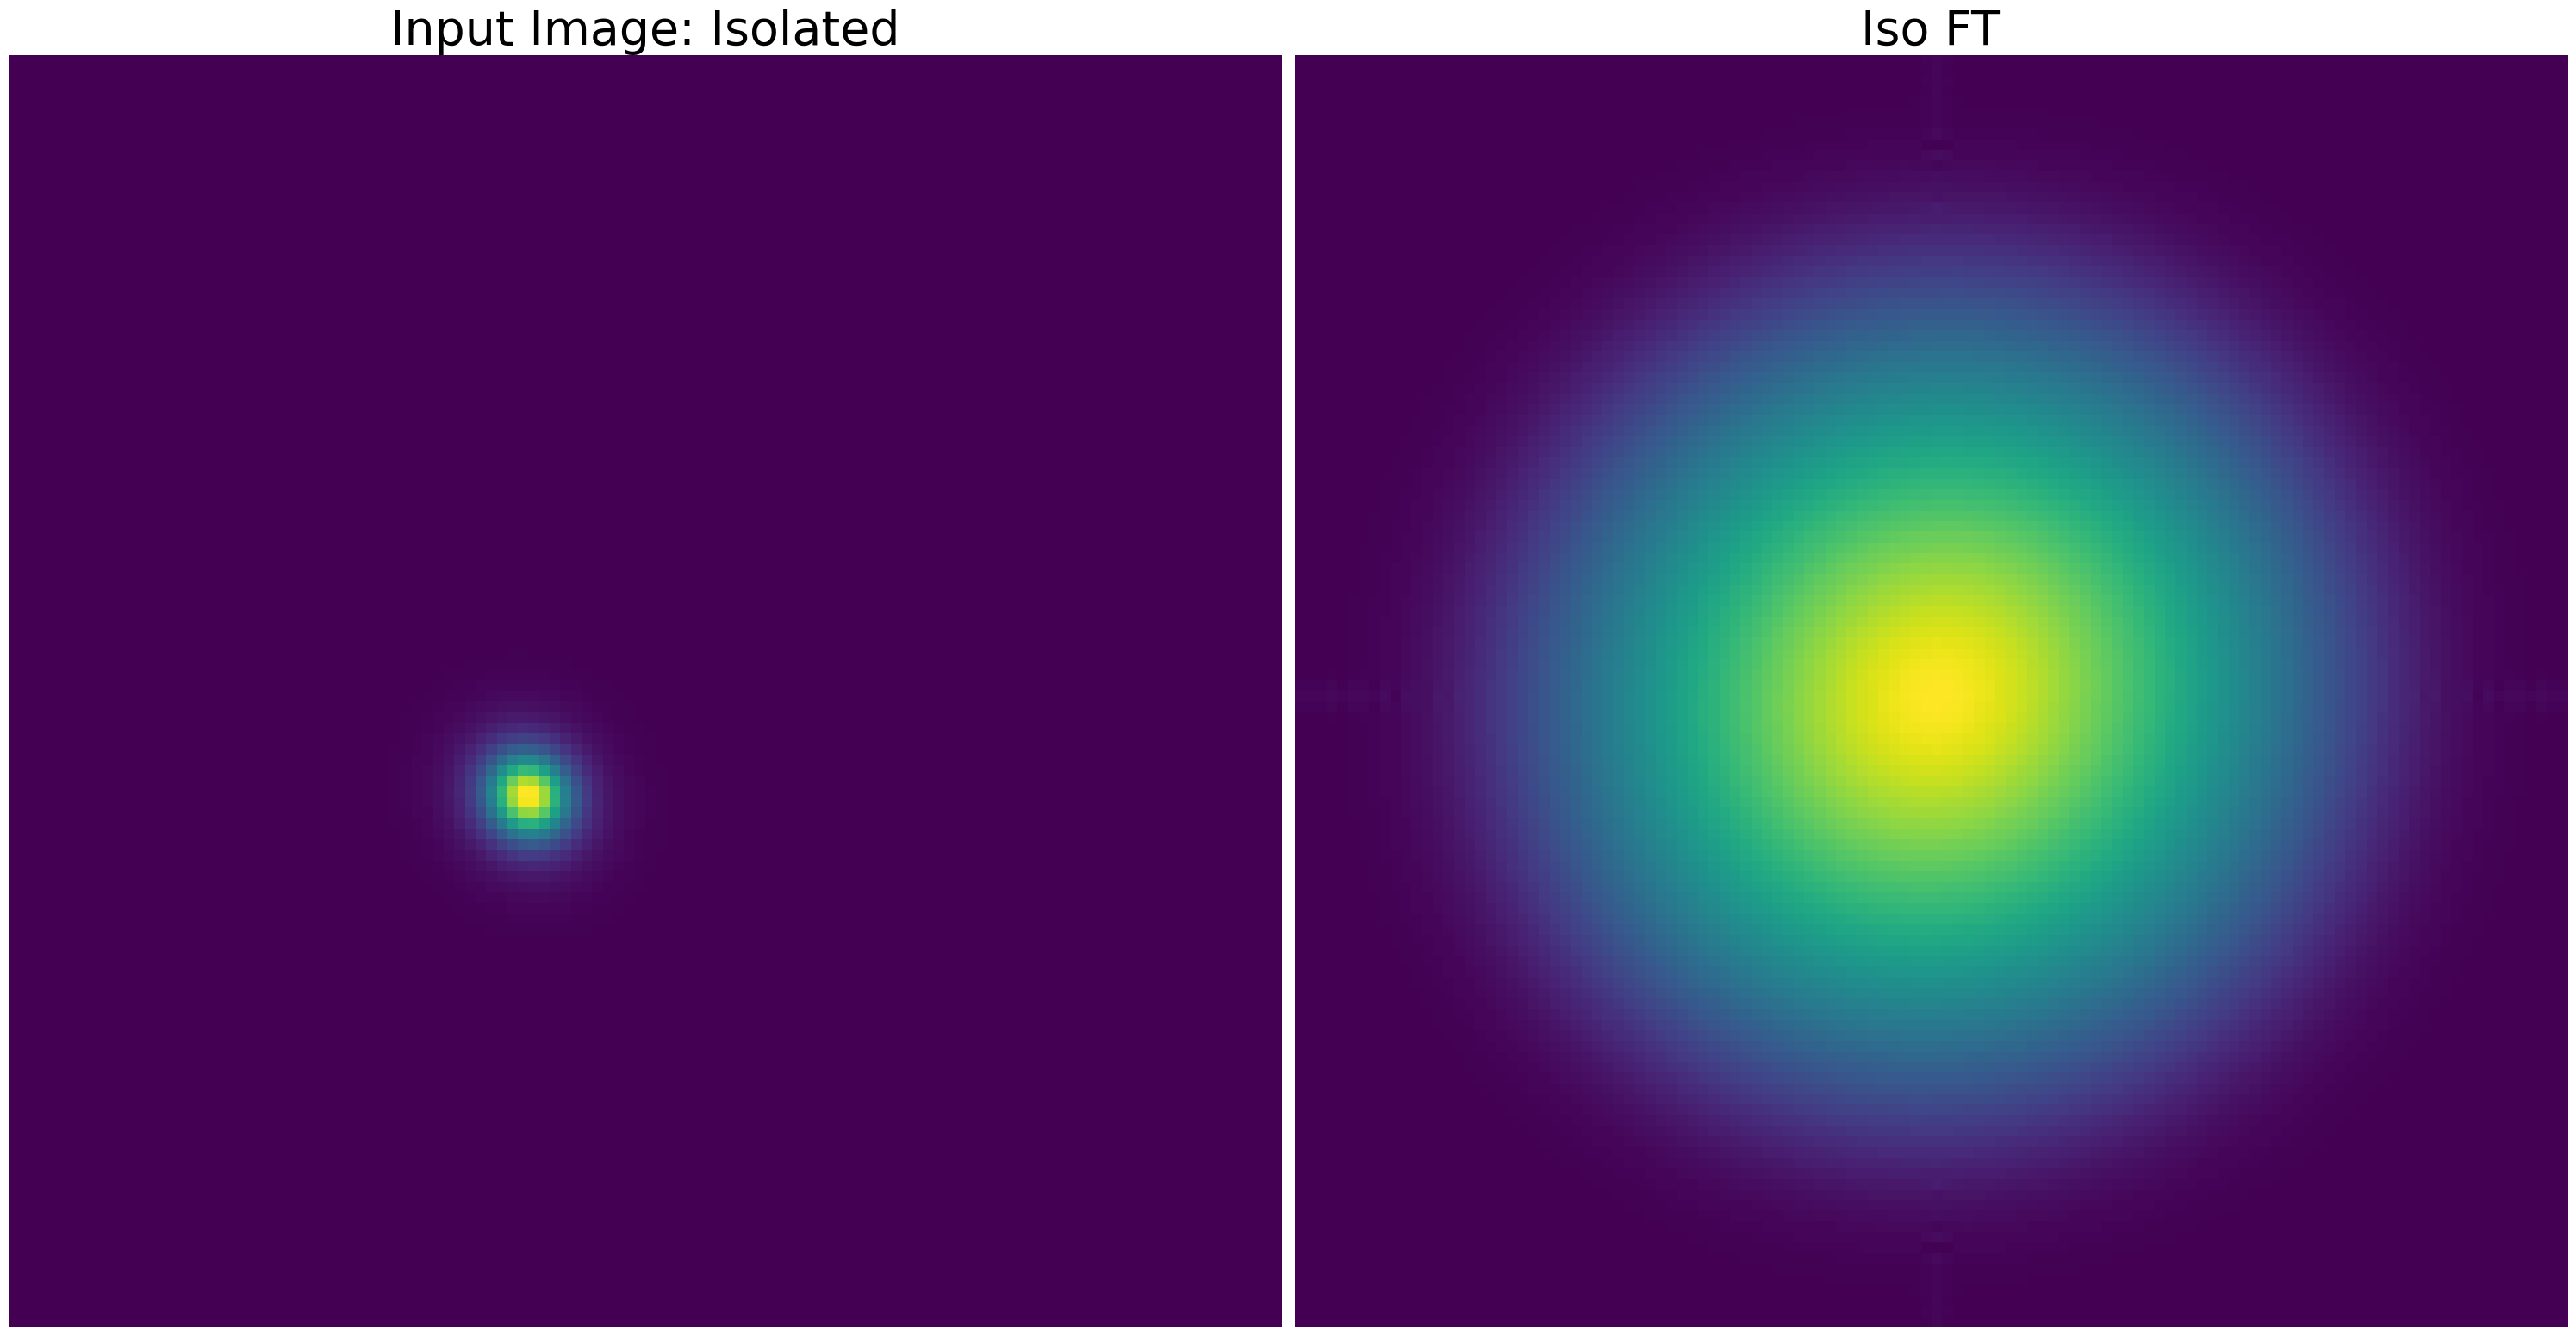

In [9]:
plot_fft(blend_img=blend_images,
         isolated_img=isolated_images, batch_i=0, filter_i=3, gal_i=0)

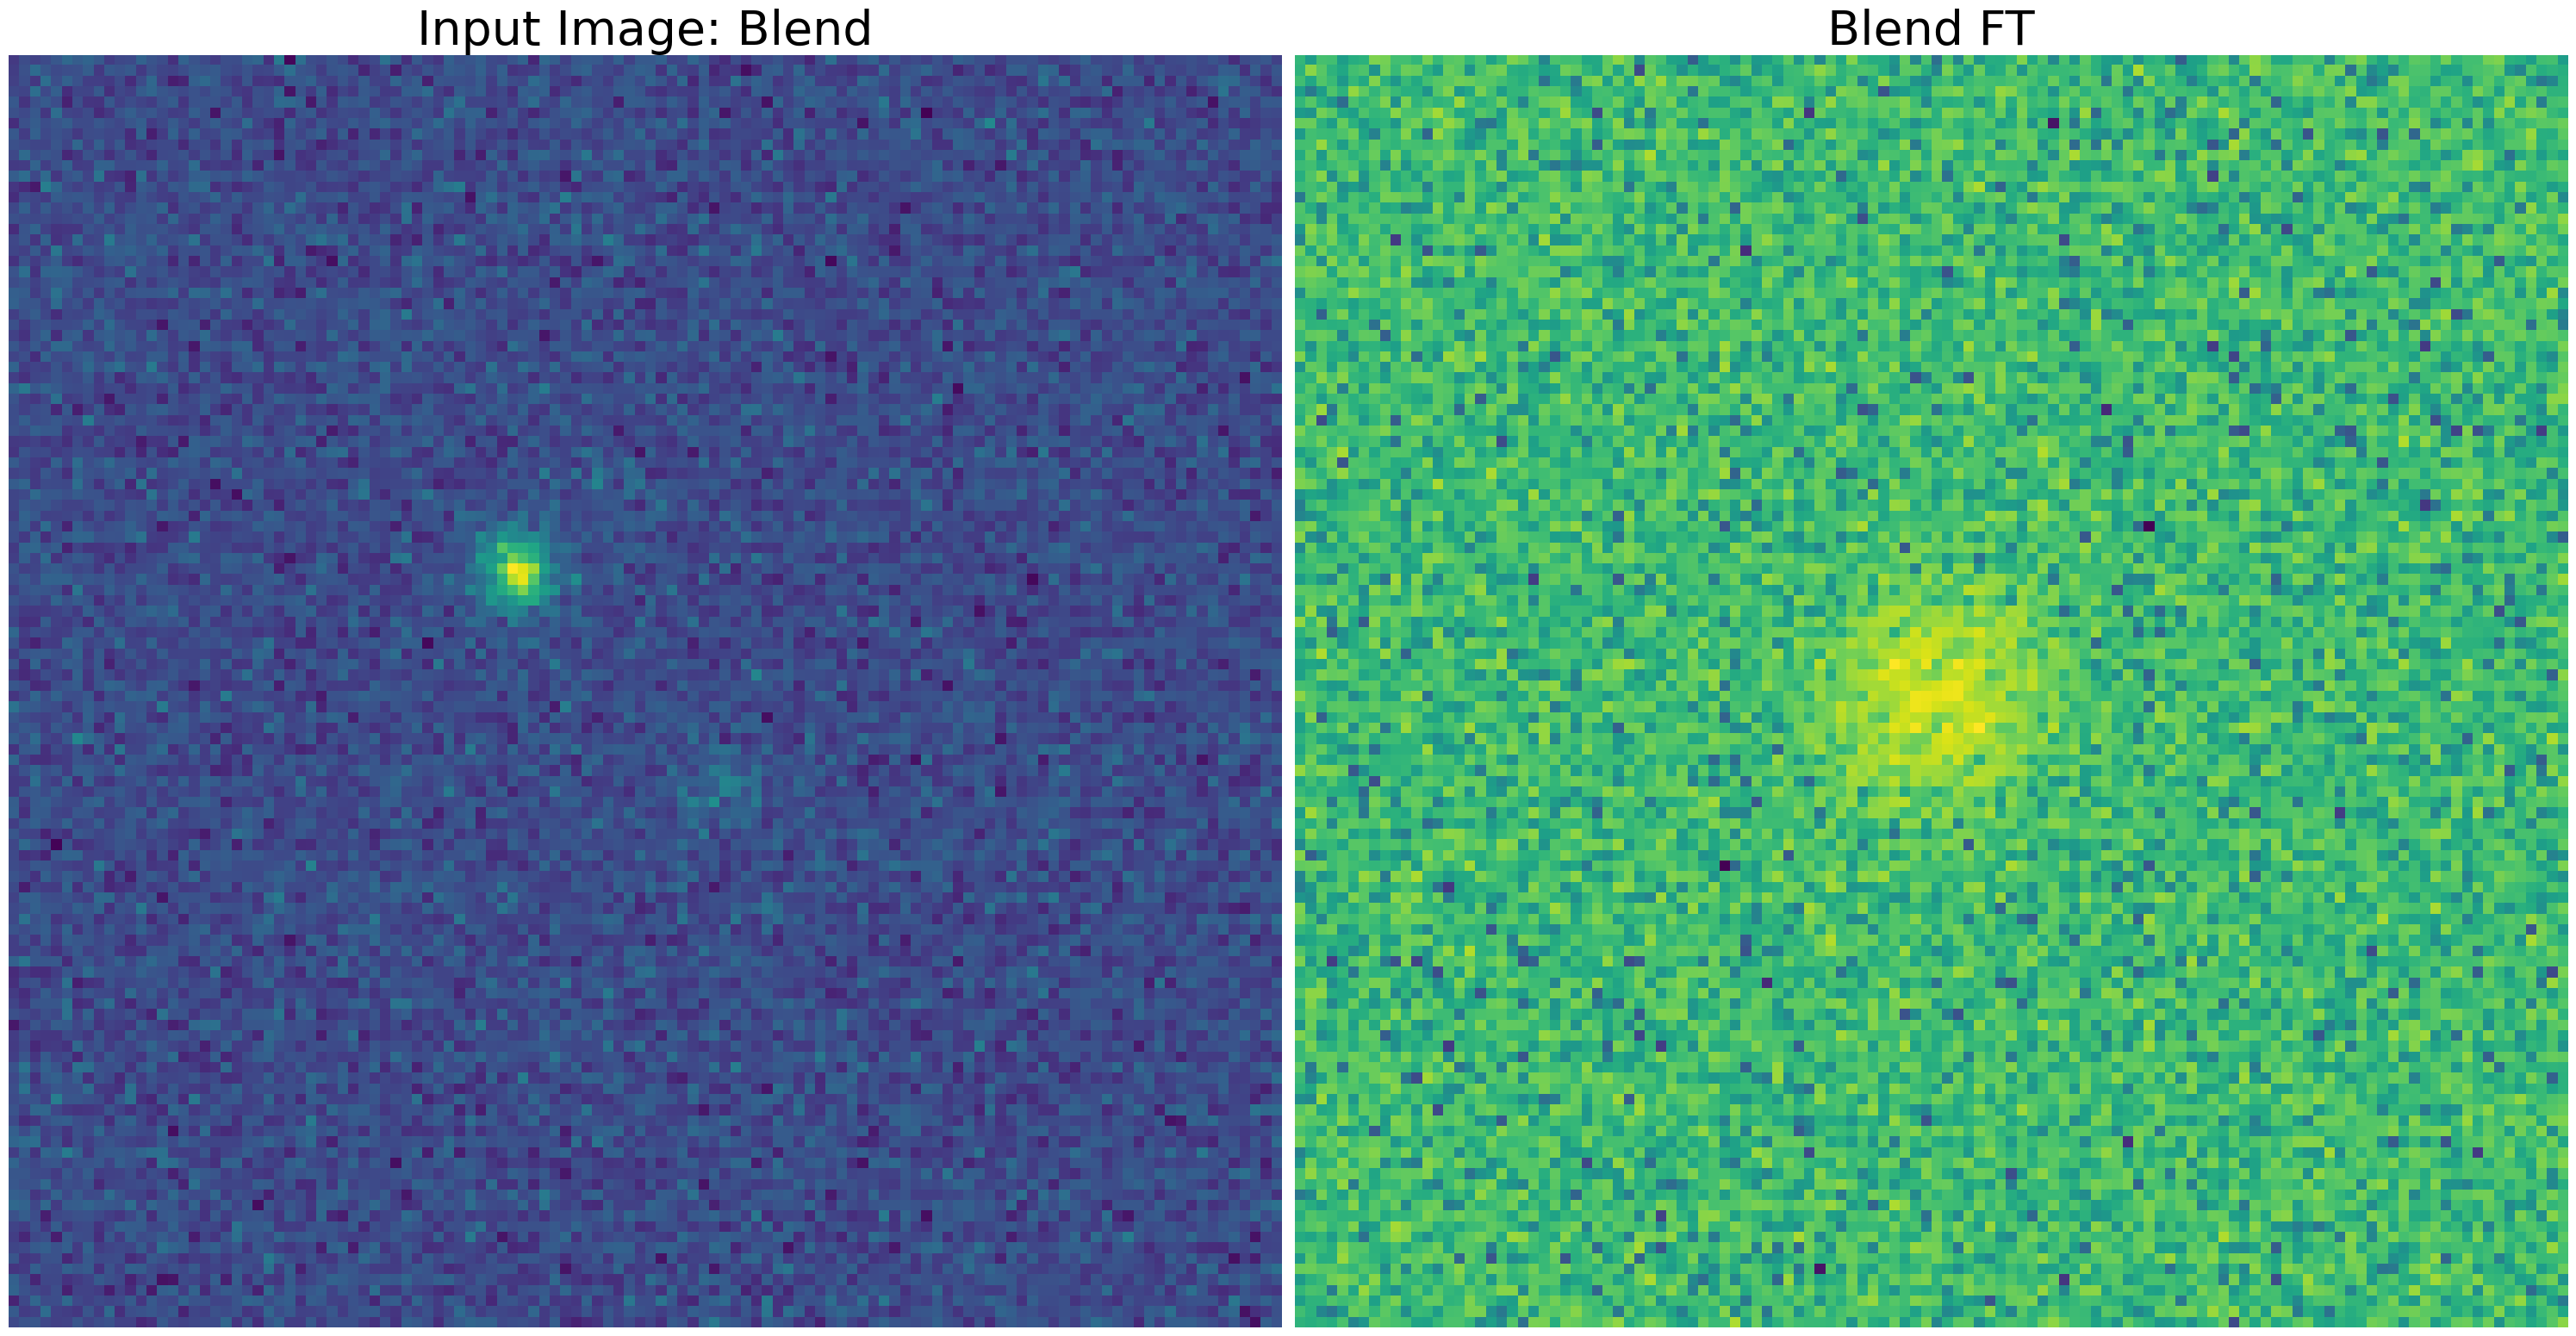

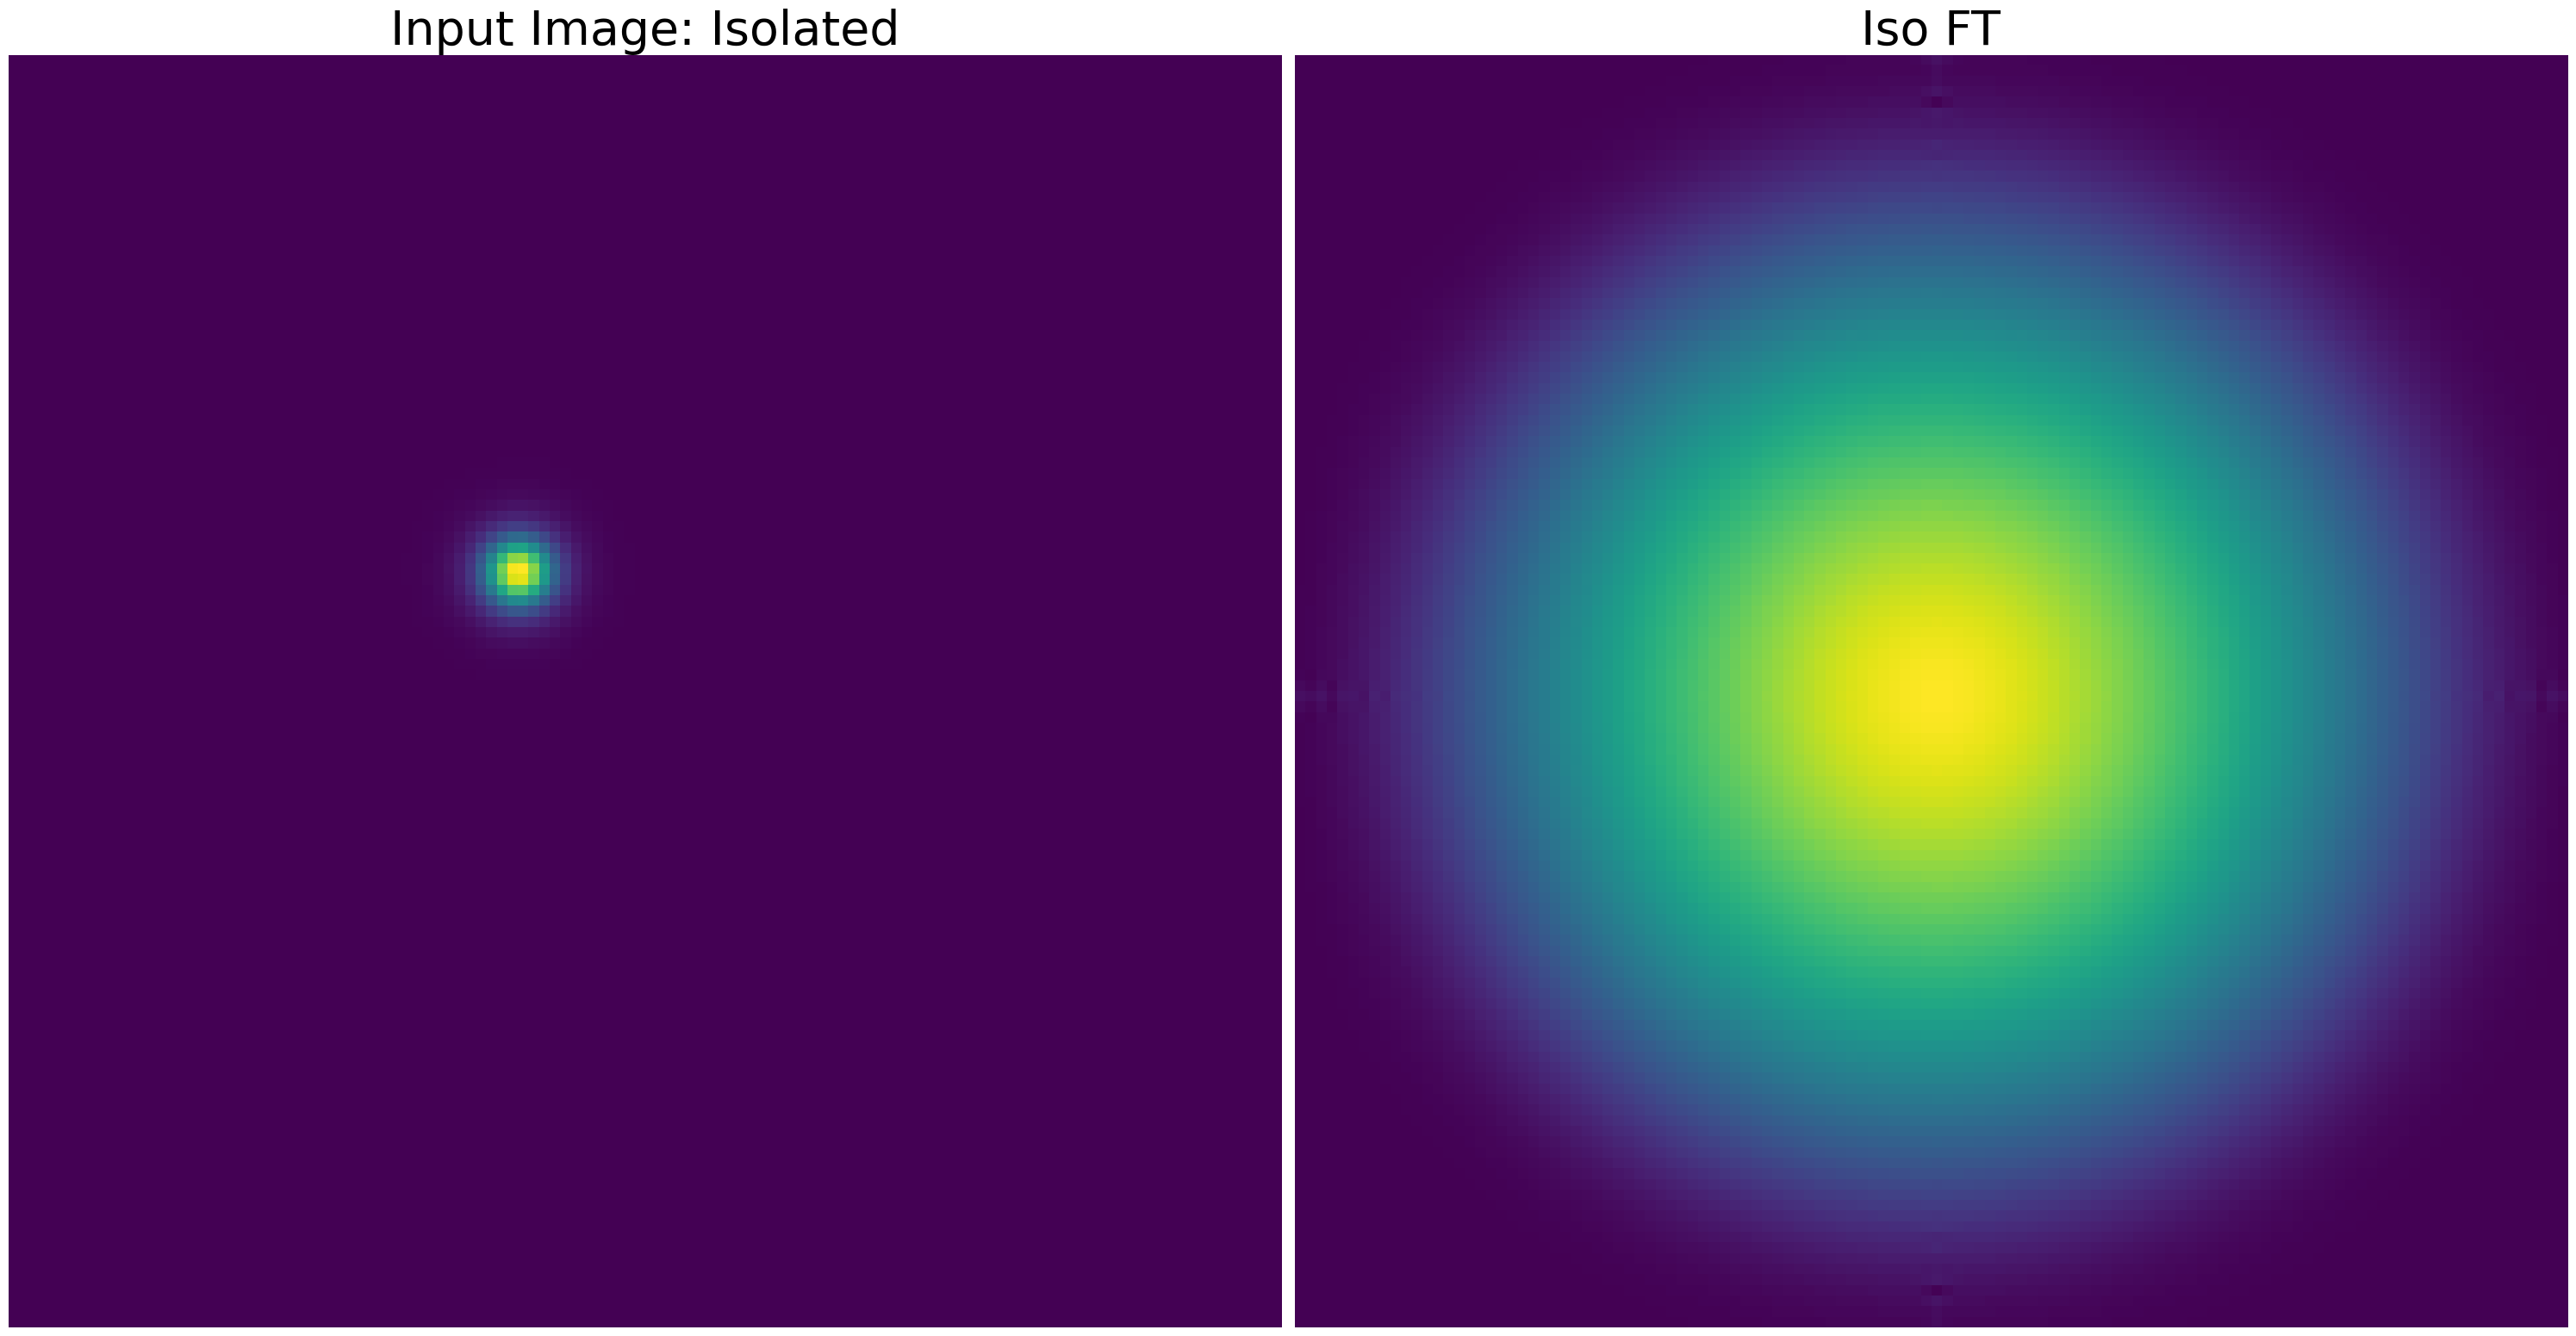

In [10]:
plot_fft(blend_img=blend_images,
         isolated_img=isolated_images, batch_i=1, filter_i=5, gal_i=1)